In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)

In [2]:
#create a label column
label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
traindf['label']=label    

label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
testdf['label']=label

In [3]:
from sklearn.model_selection import train_test_split

X = traindf.loc[:,'image_id']
y = traindf.loc[:,'label']

train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 27, 
                                                  stratify=y)

In [4]:
df_train= pd.DataFrame(columns=['image_id','label'])
df_train['image_id'] = train_x
df_train['label'] = train_y

df_val= pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = val_x
df_val['label'] = val_y

In [5]:
#uncomment according to the architecture being used
# IMG_SIZE = 224 #B0
# IMG_SIZE = 240 #B1
# IMG_SIZE = 260 #B2
IMG_SIZE = 300 #B3
# IMG_SIZE = 380 #B4
# IMG_SIZE = 456 #B5
# IMG_SIZE = 528 #B6
# IMG_SIZE = 600 #B7

In [6]:
train_datagen=ImageDataGenerator(rotation_range=5,  # rotation
                                 width_shift_range=0.2,  # horizontal shift
                                 zoom_range=0.2,  # zoom
                                 horizontal_flip=True,  # horizontal flip
                                 brightness_range=[0.2,0.8] # brightness
                                 #rescale=1./255.
                                )  

train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='binary',
                                            drop_duplicates = False,
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

valid_datagen=ImageDataGenerator()#rescale=1./255.)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_val,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

test_datagen=ImageDataGenerator()#rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col=None,
                                                batch_size=30,
                                                seed=40,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_SIZE,IMG_SIZE)
                                               )

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames.


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB3

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs

    # Create the base model from the pre-trained model EfficientNet
    base_model = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")
    for layer in base_model.layers:
        layer.trainable = False
    
    # Rebuild top
    x=base_model.output
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)#(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    #x = layers.Dense(1024)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

NUM_CLASSES=1
model = build_model(num_classes=NUM_CLASSES)

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

block7b_se_expand (Conv2D)      (None, 1, 1, 2304)   223488      block7b_se_reduce[0][0]          
__________________________________________________________________________________________________
block7b_se_excite (Multiply)    (None, 10, 10, 2304) 0           block7b_activation[0][0]         
                                                                 block7b_se_expand[0][0]          
__________________________________________________________________________________________________
block7b_project_conv (Conv2D)   (None, 10, 10, 384)  884736      block7b_se_excite[0][0]          
__________________________________________________________________________________________________
block7b_project_bn (BatchNormal (None, 10, 10, 384)  1536        block7b_project_conv[0][0]       
__________________________________________________________________________________________________
block7b_drop (Dropout)          (None, 10, 10, 384)  0           block7b_project_bn[0][0]         
__________

In [8]:
#how this model performs on this data before fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

25/25 [==============================] - 141s 6s/step - loss: 0.6422 - accuracy: 0.6700


[0.6422470211982727, 0.6700000166893005]

In [10]:
import time
from keras.callbacks import TensorBoard

NAME="Basic_modelExt-{}".format(int(time.time()))
path = "logs\\fit\\" + NAME
tensorboard_callback_fe = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

In [11]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# simple early stopping
es_fe = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_fe = tf.keras.callbacks.ModelCheckpoint('saved_model/best_basic_binaryclassf_featurextr', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

hist=model.fit(train_generator,
               epochs=12,
               validation_data=valid_generator,
               verbose=1,
               callbacks=[es_fe, mc_fe, tensorboard_callback_fe]
              )


Epoch 1/12
  1/100 [..............................] - ETA: 0s - loss: 0.6962 - accuracy: 0.5000WARNING:tensorflow:From C:\Users\rafag\anaconda3\envs\BaselineEnv\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.6206
Epoch 00001: val_loss improved from inf to 0.54915, saving model to saved_model\best_basic_binaryclassf_featurextr
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model\best_basic_binaryclassf_featurextr\assets
100/100 [==============================] - 945s 9s/step - loss: 0.6868 - accuracy: 

In [12]:
# Save the entire model as a SavedModel.
#model.save('saved_model/basic_binaryclassf_featureextr')

# load model
new_modelExt = tf.keras.models.load_model('saved_model/basic_binaryclassf_featureextr')
#model.summary()

In [13]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        layer.trainable = False
        
    for layer in model.layers[-35:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(new_modelExt)

for l in new_modelExt.layers:
    print(l.name, l.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv Fal

In [14]:
NAME="Basic_model-{}".format(int(time.time()))
path = "logs\\fit\\" + NAME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)

In [15]:
# simple early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('saved_model/best_basic_binaryclassf', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

hist=new_modelExt.fit(train_generator,
               epochs=8,
               validation_data=valid_generator,
               verbose=1,
               callbacks=[es, mc, tensorboard_callback]
              )


Epoch 1/8
100/100 [==============================] - ETA: 0s - loss: 0.4878 - accuracy: 0.7944
Epoch 00001: val_loss improved from inf to 0.42467, saving model to saved_model\best_basic_binaryclassf
INFO:tensorflow:Assets written to: saved_model\best_basic_binaryclassf\assets
100/100 [==============================] - 693s 7s/step - loss: 0.4878 - accuracy: 0.7944 - val_loss: 0.4247 - val_accuracy: 0.8200
Epoch 2/8
100/100 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8119
Epoch 00002: val_loss improved from 0.42467 to 0.41197, saving model to saved_model\best_basic_binaryclassf
INFO:tensorflow:Assets written to: saved_model\best_basic_binaryclassf\assets
100/100 [==============================] - 638s 6s/step - loss: 0.4305 - accuracy: 0.8119 - val_loss: 0.4120 - val_accuracy: 0.8350
Epoch 3/8
100/100 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8269
Epoch 00003: val_loss did not improve from 0.41197
100/100 [=======================

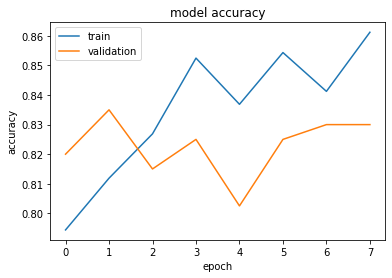

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

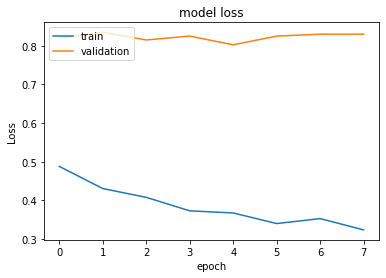

In [17]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_accuracy"])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [18]:
# load model
new_model = tf.keras.models.load_model('saved_model/best_basic_binaryclassf')

In [19]:
#how this model performs after fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
new_model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

25/25 [==============================] - 89s 4s/step - loss: 0.4103 - accuracy: 0.8250


[0.41028332710266113, 0.824999988079071]

In [20]:
test_generator.reset()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=new_model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

20/20 [==============================] - 282s 14s/step
